In [1]:
import networkx as nx
import networkx.algorithms.community as nx_comm

from utilities import import_networks
from networkx.algorithms.community.centrality import girvan_newman

import matplotlib.pyplot as plt
import numpy as np

import itertools
from tqdm.notebook import tqdm

In [2]:
networks = import_networks()

print("\n".join([str(x) for x in networks]))

Graph with 1001 nodes and 75862 edges
Graph with 999 nodes and 75415 edges
Graph with 1025 nodes and 80306 edges
Graph with 1018 nodes and 80077 edges


In [3]:
#Remove edges
for g in networks:
    g.remove_edges_from([v for v in g.edges(data=True) if v[2]["weight"] < 90])

for g in networks:
    g.remove_nodes_from(list(nx.isolates(g)))
print("\n".join([str(x) for x in networks]))

Graph with 362 nodes and 674 edges
Graph with 347 nodes and 655 edges
Graph with 435 nodes and 1017 edges
Graph with 444 nodes and 1094 edges


## Finding Communities
---

In [4]:
from multiprocessing import Pool
import itertools

def chunks(l, n):
    """Divide a list of nodes `l` in `n` chunks"""
    l_c = iter(l)
    while 1:
        x = tuple(itertools.islice(l_c, n))
        if not x:
            return
        yield x


def betweenness_centrality_parallel(G, processes=None):
    """Parallel betweenness centrality  function"""
    p = Pool(processes=processes)
    node_divisor = len(p._pool) * 4
    node_chunks = list(chunks(G.nodes(), int(G.order() / node_divisor)))
    num_chunks = len(node_chunks)
    bt_sc = p.starmap(
        nx.edge_betweenness_centrality_subset,
        zip(
            [G] * num_chunks,
            node_chunks,
            [list(G)] * num_chunks,
            [True] * num_chunks,
            ["weight"] * num_chunks,
        ),
    )

    # Reduce the partial solutions
    bt_c = bt_sc[0]
    for bt in bt_sc[1:]:
        for n in bt:
            bt_c[n] += bt[n]
    return bt_c


In [5]:
def most_valuable(G):
    centrality = nx.edge_betweenness_centrality(G, weight='weight_1')
    return max(centrality,key=centrality.get)
def most_valuable_parallel(G):
    centrality = betweenness_centrality_parallel(G)
    return max(centrality,key=centrality.get)

In [9]:
%%time
k = 4
gn_iterator = [girvan_newman(g,most_valuable_parallel) for g in networks[0:1]]
limited = [itertools.takewhile(lambda c: len(c) >= 0, comp) for comp in gn_iterator]
for communities in limited[0]:
    # gn_comms = [tuple(c for c in comm) for comm in communities]
    com = tuple(list(c) for c in communities)
    print(f"{len(com)}: {[len(x) for x in com]}")
    break

27: [163, 68, 2, 48, 2, 3, 3, 2, 6, 18, 2, 2, 2, 8, 2, 3, 2, 2, 4, 3, 3, 2, 4, 2, 2, 2, 2]
CPU times: user 137 ms, sys: 86.8 ms, total: 224 ms
Wall time: 319 ms


In [10]:
import json
with open("comm.json","w") as f:
    json.dump(com,f)

In [75]:
%%time
from multiprocessing.pool import ThreadPool as Pool

def unpack(it):
    r = tuple(c for c in it) 
    print("Unpacked")
    return r

gn_iterator = [girvan_newman(g,most_valuable_parallel) for g in networks]

with Pool() as p:
    p.map(unpack,gn_iterator)
    # for each_item in p.imap(unpack,gn_iterator):
    #     pass
    # p.close()
    # p.join()
# threads = [Process(target=unpack,args=it) for it in gn_iterator]

# for thread in threads:
#     thread.start()
# for thread in threads:
#     thread.join()

KeyboardInterrupt: 

In [74]:
def generator(n):
    i = 0
    while i<1e2*n:
        yield i
        i += 1

def unpack(gen):
    return [x for x in next(gen)]

list_of_generators = [generator(n) for n in range(2,7)]
generator_results =  [unpack(gen) for gen in list_of_generators]

TypeError: 'int' object is not iterable

In [54]:
from multiprocessing import Pool
import time
import itertools

import matplotlib.pyplot as plt
import networkx as nx


def chunks(l, n):
    """Divide a list of nodes `l` in `n` chunks"""
    l_c = iter(l)
    while 1:
        x = tuple(itertools.islice(l_c, n))
        if not x:
            return
        yield x


def betweenness_centrality_parallel(G, processes=None):
    """Parallel betweenness centrality  function"""
    p = Pool(processes=processes)
    node_divisor = len(p._pool) * 4
    node_chunks = list(chunks(G.nodes(), int(G.order() / node_divisor)))
    num_chunks = len(node_chunks)
    bt_sc = p.starmap(
        nx.edge_betweenness_centrality_subset,
        zip(
            [G] * num_chunks,
            node_chunks,
            [list(G)] * num_chunks,
            [True] * num_chunks,
            ["weight_1"] * num_chunks,
        ),
    )

    # Reduce the partial solutions
    bt_c = bt_sc[0]
    for bt in bt_sc[1:]:
        for n in bt:
            bt_c[n] += bt[n]
    return bt_c


# _ = """
for G in [networks[0]]:
    print("")
    print("Computing betweenness centrality for:")
    print(nx.info(G))
    print("\tParallel version")
    start = time.time()
    bt = betweenness_centrality_parallel(G)
    print(f"\t\tBetweenness centrality for node 0:{max(bt,key=bt.get)}")
    print(f"\t\tTime: {(time.time() - start):.4F} seconds")
    print("\tNon-Parallel version")
    start = time.time()
    bt = nx.edge_betweenness_centrality(G,weight="weight_1")
    print(f"\t\tBetweenness centrality for node 0: {max(bt,key=bt.get)}")
    print(f"\t\tTime: {(time.time() - start):.4F} seconds")
# """


Computing betweenness centrality for:
Graph with 1001 nodes and 823 edges
	Parallel version
		Betweenness centrality for node 0:('7002_9500', '1511_9555')
		Time: 0.6211 seconds
	Non-Parallel version
		Betweenness centrality for node 0: ('7002_9500', '1511_9555')
		Time: 1.5517 seconds


In [162]:
#Modularity scores:
modularity_scores = [nx_comm.modularity(g,comm,weight="weight") for g,comm in zip(networks,modularity_communities)]
print(modularity_scores)

partition_quality = [nx_comm.partition_quality(g,comm) for g,comm in zip(networks,modularity_communities)]
print(partition_quality)

[0.5853419848395155, 0.5744591553335524, 0.6081425839562082, 0.6073114146403099]
[(0.5304632095120086, 0.8026113886113886), (0.5176025989524631, 0.800806818842891), (0.4992155007097851, 0.8085194359756097), (0.4758295140926858, 0.8176133433014008)]


## Test resolution parameter

In [ ]:
# Obtain modularity communities
def get_modullarity_communities(G:nx.Graph,resolution=1,result = None,year = None):
    modularity_communities = [list(greedy_modularity_communities(g,weight='weight',resolution = r)) for r in resolution] 
    if result is not None:
        result[year] = modularity_communities
    return(modularity_communities)

In [ ]:
%%time
communities_by_resolution =  {}
resulutions = np.arange(0,1,0.1)
resolutions = np.append(np.arange(0,1,0.2),np.arange(1,25,0.5))
print(resolutions)
for g,year in zip(networks,range(2018,2022)):
    communities_by_resolution[year] = [[list(x) for x in y] for y in get_modullarity_communities(g,resolution=resolutions)]

In [140]:
#Classify Communities
communities_statistics = {}
for (year,comms),g,r in  zip(communities_by_resolution.items(),networks,resolutions):
    communities_statistics[year] = {"N_communities": [len(x) for x in comms ],
                                    "Avg_comm_size": [np.average([len(y) for y in x]) for x in comms],
                                    "Sigma_comm_size": [np.std([len(y) for y in x]) for x in comms],
                                    "Median_comm_size": [np.median([len(y) for y in x]) for x in comms],
                                    "Modularity_score": [nx_comm.modularity(g,c,resolution=r,weight='weight') for c in comms]}

In [ ]:
# Export Data
import json
with open("data/modularity_communities.json", "w") as f:
    json.dump(communities_by_resolution,f)
with open("data/modularity_communities_statistics.json", "w") as f:
    json.dump(communities_statistics,f)

## Visualize Data
---

In [3]:
#Import data
import json
with open("data/modularity_communities_statistics.json", "r") as f:
    communities_statistics = json.load(f)
with open("data/modularity_communities.json", "r") as f:
    communities_by_resolution = json.load(f)

resolutions = np.append(np.arange(0,1,0.2),np.arange(1,25,0.5))

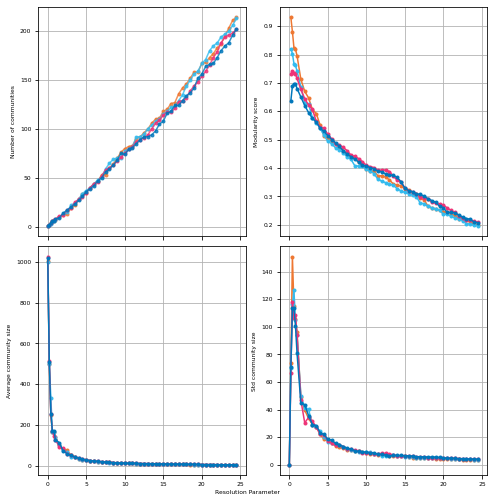

In [141]:
#Visualize statistics
colors = ['#EE7732', '#33BBEE',  '#EE3377',  '#0077BB']
colors = dict(zip(range(2018,2022),colors))

plt.rcParams.update({'font.size': 6})
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
plt.rc('ytick', labelsize=6)    
plt.rc('axes', titlesize=6)    


cm = 1/2.54
fig,ax = plt.subplots(ncols=2,nrows=2,figsize=(2*8.7*cm,2*8.7*cm),sharex=True)
fig.text(0.5, 0.00, 'Resolution Parameter', ha='center')

ax[0,0].set(ylabel="Number of communities")
# ax[0,1].set(xlabel="Resolution parameter", ylabel="Median community size")
ax[0,1].set( ylabel="Modularity score",yscale="linear")
ax[1,0].set( ylabel="Average community size",yscale="linear")
ax[1,1].set( ylabel="Std community size",yscale="linear")
for year, data in communities_statistics.items():
    ax[0,0].plot(resolutions,data["N_communities"],label=year, marker='o', ms=3,alpha=0.8, color = colors[int(year)])
    # ax[0,1].plot(resolutions,data["Median_comm_size"],label=year, marker='o', ms=3, color = colors[int(year)])
    ax[0,1].plot(resolutions[1:],data["Modularity_score"][1:],label=year, marker='o', ms=3, color = colors[int(year)])
    ax[1,0].plot(resolutions,data["Avg_comm_size"],label=year, marker='o', ms=3, color = colors[int(year)])
    ax[1,1].plot(resolutions,data["Sigma_comm_size"],label=year, marker='o', ms=3, color = colors[int(year)])
             

for a in ax.flatten():
    a.grid()
    # a.set_xticks(a.get_xticks())
    # a.set_xticklabels(a.get_xticklabels(),fontdict={"fontsize":6})
    # a.legend()
# ax[0,0].grid()
# ax[0,1].grid()
# ax[0,0].legend()
# ax[0,1].legend()
plt.tight_layout()
plt.savefig("modularity_community_statistics.pdf",dpi=200)
# plt.savefig("modularity_community_statistics.png",dpi=200)

In [ ]:
from scipy.stats import norm

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))
ax.set(xlabel="Community size", ylabel="p")

x = np.linspace(0,150,200)
for average,std in zip(communities_statistics[2018]["Avg_comm_size"],communities_statistics[2018]["Sigma_comm_size"]):
    ax.plot(x,norm(loc=average,scale=std).pdf(x),label=year, marker='',ls='-', ms=3)
             
ax.grid()
# ax.legend()

In [ ]:
resolutions

In [ ]:
g = networks[0]
comm = [[g.nodes[y]["name"] for y in x] for x in communities_by_resolution["2018"][6]]
print(comm[2])
print()
print(comm[3])

areas_in_comm = []
for a in comm:
    unique = list(set(a))
    areas_in_comm.append({area: a.count(area) for area in unique})
    # print(a)
print(areas_in_comm)
print()

In [5]:
# Find matching communities
def enumerate_simmilarity(d1,d2):
    scores = []
    simmilarity = lambda d,d1: len(d1.keys() & d.keys()) * sum([d1[c]*d[c]/(1+abs(d1[c]-d[c])) for c in (d1.keys() & d.keys())])
    for d in d1:
        scores.append([simmilarity(d,dd) for dd in d2])
        
    scores = np.array(scores,dtype=float)
    best = np.full(len(d1),-1)
        
    for i in range(len(d1)):
        index = np.unravel_index(scores.argmax(),scores.shape)
        best[index[0]] = index[1]
        scores[index[0]] = -1
        scores[:,index[1]] = -1
     
    return list(zip(best,d1))

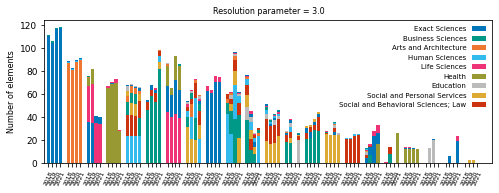

In [8]:
colors = ['#BBBBBB', '#EE7732', '#33BBEE', '#CC3311', '#009988', '#EE3377',  '#0077BB','#DDAA33', '#999933']
areas  = ['Educação', 'Artes e Arquitetura',
          'Humanidades', 'Direito, Ciências Sociais e do Comportamento', 'Ciências Empresariais', 
          'Ciências da Vida', 'Ciências Exatas', 'Serviços Sociais e Pessoais', 'Saúde']
areas_en  = ['Education', 'Arts and Architecture',
          'Human Sciences', 'Social and Behavioral Sciences; Law', 'Business Sciences', 
          'Life Sciences', 'Exact Sciences', 'Social and Personal Services', 'Health']
areas_en=dict(zip(areas,areas_en))
area_colors = dict(zip(areas,colors))
# plt.rcparams()
plt.rcParams.update({'font.size': 9})


x0 = 0

cm = 1/2.54
fig,ax = plt.subplots(figsize=(17.8*cm,7*cm))

resolution_index = 9
areas_in_comm = []
for n, G in enumerate(networks):
    comm = [[G.nodes[y]["area"] for y in x] for x in communities_by_resolution[str(G.graph["year"])][resolution_index]]
    areas_in_comm.append([{area: a.count(area) for area in list(set(a))} for a in comm])
    
max_idx = areas_in_comm.index(max(areas_in_comm, key = len))
max_comms = max(areas_in_comm, key = len)
max_comms_enum = list(enumerate(max_comms))

for i in range(0,4):
    if i == max_idx: 
        areas_in_comm[i] = max_comms_enum
        continue
    areas_in_comm[i] = enumerate_simmilarity(areas_in_comm[i], max_comms)
    
for n, (G,areas_year) in enumerate(zip(networks,areas_in_comm)):
    y_offset = 0
    for i,area in areas_year:
        y_offset = 0
        parts = list(area.items())
        parts.sort(reverse=True,key = lambda x: x[1])
        for j,(a,count) in enumerate(parts):
            ax.bar(x0 + i*5+n,count,bottom=y_offset,color=area_colors[a],label=areas_en[a])
            y_offset += count

years = list(range(2018,2022))*len(max_comms)
idx = [x0 + i*5 + j for i in range(len(max_comms)) for j in range(4)]        
            
ax.set_xticks(idx)
ax.set_xticklabels(years, rotation=65, fontdict={"fontsize":6})

ax.set(xlim=(-1,ax.get_xlim()[1]-1))

ax.set_title(f"Resolution parameter = {resolutions[resolution_index]}", fontdict={"fontsize":8})

ax.set_ylabel(f"Number of elements", fontdict={"fontsize":8})
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1,1), loc="upper right",
            fontsize=7, markerfirst=False, frameon=False)

plt.tight_layout()
plt.savefig("comm.pdf")
# plt.savefig("comm.jpeg",dpi=200)

# Louvain
---

In [3]:
import community as community_louvain

In [4]:
%%time
louvain_dicts = [community_louvain.best_partition(g) for g in networks]
louvain_comms = {}
for g,ldict in zip(networks, louvain_dicts):
    louvain_comms[g.graph["year"]] = sorted([[node for node,c in ldict.items() if c==n] for n in set(ldict.values())],key=len,reverse=True)

CPU times: user 7.35 s, sys: 0 ns, total: 7.35 s
Wall time: 7.36 s


In [5]:
modularity_scores = [nx_comm.modularity(g,comm,weight="weight") for g,comm in zip(networks,louvain_comms.values())]
print(modularity_scores)

[0.5872495667613756, 0.580970071562319, 0.6149370219414844, 0.6134974515449109]


In [7]:
# Find matching communities
def enumerate_simmilarity(d1,d2):
    scores = []
    simmilarity = lambda d,d1: len(d1.keys() & d.keys()) * sum([d1[c]*d[c]/(1+abs(d1[c]-d[c])) for c in (d1.keys() & d.keys())])
    for d in d1:
        scores.append([simmilarity(d,dd) for dd in d2])
        
    scores = np.array(scores,dtype=float)
    best = np.full(len(d1),-1)
        
    for i in range(len(d1)):
        index = np.unravel_index(scores.argmax(),scores.shape)
        best[index[0]] = index[1]
        scores[index[0]] = -1
        scores[:,index[1]] = -1
     
    return list(zip(best,d1))


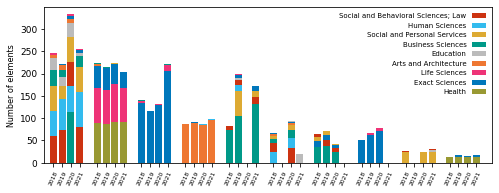

In [9]:
colors = ['#BBBBBB', '#EE7732', '#33BBEE', '#CC3311', '#009988', '#EE3377',  '#0077BB','#DDAA33', '#999933']
areas  = ['Educação', 'Artes e Arquitetura',
          'Humanidades', 'Direito, Ciências Sociais e do Comportamento', 'Ciências Empresariais', 
          'Ciências da Vida', 'Ciências Exatas', 'Serviços Sociais e Pessoais', 'Saúde']
areas_en  = ['Education', 'Arts and Architecture',
          'Human Sciences', 'Social and Behavioral Sciences; Law', 'Business Sciences', 
          'Life Sciences', 'Exact Sciences', 'Social and Personal Services', 'Health']
areas_en=dict(zip(areas,areas_en))
area_colors = dict(zip(areas,colors))
# plt.rcparams()
plt.rcParams.update({'font.size': 9})


x0 = 0

cm = 1/2.54
fig,ax = plt.subplots(figsize=(17.8*cm,7*cm))

areas_in_comm = []
for n, G in enumerate(networks):
    comm = [[G.nodes[y]["area"] for y in x] for x in louvain_comms[G.graph["year"]]]
    areas_in_comm.append([{area: a.count(area) for area in list(set(a))} for a in comm])
    
max_idx = areas_in_comm.index(max(areas_in_comm, key = len))
max_comms = max(areas_in_comm, key = len)
max_comms_enum = list(enumerate(max_comms))

for i in range(0,4):
    if i == max_idx: 
        areas_in_comm[i] = max_comms_enum
        continue
    areas_in_comm[i] = enumerate_simmilarity(areas_in_comm[i], max_comms)
    
for n, (G,areas_year) in enumerate(zip(networks,areas_in_comm)):
    y_offset = 0
    for i,area in areas_year:
        y_offset = 0
        parts = list(area.items())
        parts.sort(reverse=True,key = lambda x: x[1])
        for j,(a,count) in enumerate(parts):
            ax.bar(x0 + i*5+n,count,bottom=y_offset,color=area_colors[a],label=areas_en[a])
            y_offset += count

years = list(range(2018,2022))*len(max_comms)
idx = [x0 + i*5 + j for i in range(len(max_comms)) for j in range(4)]        
            
ax.set_xticks(idx)
ax.set_xticklabels(years, rotation=65, fontdict={"fontsize":6})

ax.set(xlim=(-1,ax.get_xlim()[1]-1))

# ax.set_title(f"Resolution parameter = {resolutions[resolution_index]}", fontdict={"fontsize":8})

ax.set_ylabel(f"Number of elements", fontdict={"fontsize":8})
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1,1), loc="upper right",
            fontsize=7, markerfirst=False, frameon=False)

plt.tight_layout()
plt.savefig("comm.pdf")